In [1]:
from array import array
import itertools
import time
import scipy 
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path
from matplotlib.ticker import NullFormatter

from scipy.optimize import curve_fit

#This line is important. On this server I don't know if we have the ability to output plots. This is a solution.

%matplotlib inline

#Importing root_pandas and root_numpy.

import sys
sys.path.insert(0,'/usr/common/software/rootpy/')
import root_numpy
import root_pandas as rpd
import ROOT
from root_pandas import read_root

Welcome to ROOTaaS 6.06/06


In [2]:
def getWeights(filename,dataframe):
    
    if('Skimmed_17g6a1_pthat1' in filename):
        dataframe.eval('weights = 1.60*10**(-11)',inplace=True)
    elif('Skimmed_17g6a1_pthat2' in filename):
        dataframe.eval('weights = 2.72*10**(-12)',inplace=True)
    elif('Skimmed_17g6a1_pthat3' in filename):
        dataframe.eval('weights = 3.69*10**(-13)',inplace=True)
    elif('Skimmed_17g6a1_pthat4' in filename):
        dataframe.eval('weights = 6.14*10**(-14)',inplace=True)
    elif('Skimmed_17g6a1_pthat5' in filename):
        dataframe.eval('weights = 1.27*10**(-14)',inplace=True)
    
    elif('Skimmed_17g6a3_pthat1' in filename):
        dataframe.eval('weights = 4.47*10**(-11)',inplace=True)
    elif('Skimmed_17g6a3_pthat2' in filename):
        dataframe.eval('weights = 9.83*10**(-11)',inplace=True)
    elif('Skimmed_17g6a3_pthat3' in filename):
        dataframe.eval('weights = 1.04*10**(-10)',inplace=True)
    elif('Skimmed_17g6a3_pthat4' in filename):
        dataframe.eval('weights = 1.01*10**(-10)',inplace=True)
    elif('Skimmed_17g6a3_pthat5' in filename):
        dataframe.eval('weights = 6.93*10**(-11)',inplace=True)
    elif('Skimmed_17g6a3_pthat6' in filename):
        dataframe.eval('weights = 5.13*10**(-11)',inplace=True)
    elif('Skimmed_17g6a3_pthat7' in filename):
        dataframe.eval('weights = 3.03*10**(-11)',inplace=True)
    elif('Skimmed_17g6a3_pthat8' in filename):
        dataframe.eval('weights = 1.89*10**(-11)',inplace=True)
    
    else:
        dataframe.eval('weights = eg_cross_section/eg_ntrial',inplace=True)
        
    return dataframe

In [3]:
def getCluster04(inputFiles):
    
    scalarColumns = []
    scalarColumns.append('eg_cross_section')
    scalarColumns.append('eg_ntrial')
    scalarColumns.append('ue_estimate_its_const')

    arrayColumns = []
    arrayColumns.append('cluster_pt')
    arrayColumns.append('cluster_eta')
    arrayColumns.append('cluster_ncell')
    arrayColumns.append('cluster_e_cross')
    arrayColumns.append('cluster_e')
    arrayColumns.append('cluster_e_max')
    arrayColumns.append('cluster_tof')
    arrayColumns.append('cluster_nlocal_maxima')
    arrayColumns.append('cluster_distance_to_bad_channel')
    arrayColumns.append('cluster_iso_its_04')
    arrayColumns.append('cluster_iso_its_04_ue')
    arrayColumns.append('cluster_iso_04_truth')
    arrayColumns.append('cluster_NN1')
    arrayColumns.append('cluster_Lambda')
    
    arrayColumns.append('cluster_Lambda_angle')

    columns = scalarColumns + arrayColumns

    dfs = []
    for inputFile in inputFiles:
        start = time.time()
        filename = os.path.basename(inputFile)
        dataframe = rpd.read_root(inputFile, columns=columns, flatten=arrayColumns)
        end = time.time()
        getWeights(filename,dataframe)
        print 'Processed {0} in {1} seconds'.format(filename, end - start)
        dfs.append(dataframe)

    return pd.concat(dfs).drop_duplicates().reset_index(drop=True)

In [4]:
pPbFiles       = ['Skimmed_13def_ptmin12.0_Nevent_1416399.root']
pPbHist_04     = getCluster04(pPbFiles)

mc_18g7a_files = ['Skimmed_17g6a3_pthat1_ptmin12.0_Nevent_1143901.root','Skimmed_17g6a3_pthat2_ptmin12.0_Nevent_1992307.root','Skimmed_17g6a3_pthat3_ptmin12.0_Nevent_4123564.root',
                  'Skimmed_17g6a3_pthat4_ptmin12.0_Nevent_2234506.root','Skimmed_17g6a3_pthat5_ptmin12.0_Nevent_1903308.root','Skimmed_17g6a3_pthat6_ptmin12.0_Nevent_1875403.root',
                  'Skimmed_17g6a3_pthat7_ptmin12.0_Nevent_1734300.root','Skimmed_17g6a3_pthat8_ptmin12.0_Nevent_1733709.root']
mc_18g7a_04    = getCluster04(mc_18g7a_files)

Processed Skimmed_13def_ptmin12.0_Nevent_1416399.root in 57.4068379402 seconds
Processed Skimmed_17g6a3_pthat1_ptmin12.0_Nevent_1143901.root in 2.93272280693 seconds
Processed Skimmed_17g6a3_pthat2_ptmin12.0_Nevent_1992307.root in 11.062584877 seconds
Processed Skimmed_17g6a3_pthat3_ptmin12.0_Nevent_4123564.root in 40.6554288864 seconds
Processed Skimmed_17g6a3_pthat4_ptmin12.0_Nevent_2234506.root in 35.976858139 seconds
Processed Skimmed_17g6a3_pthat5_ptmin12.0_Nevent_1903308.root in 49.9434330463 seconds
Processed Skimmed_17g6a3_pthat6_ptmin12.0_Nevent_1875403.root in 62.942358017 seconds
Processed Skimmed_17g6a3_pthat7_ptmin12.0_Nevent_1734300.root in 74.0260841846 seconds
Processed Skimmed_17g6a3_pthat8_ptmin12.0_Nevent_1733709.root in 110.464931011 seconds


In [5]:
def applyCut(inputDataframe,cut,text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [6]:
def applyCuts(fullDataframe,name='default'):  
    
    fullDataframe.eval('cluster_ecross_over_e = cluster_e_cross/cluster_e',inplace=True)
    fullDataframe.eval('cluster_emax_over_e  = cluster_e_max/cluster_e'   ,inplace=True)
    fullDataframe.eval('cluster_Lambda_Angle = 1.62*cluster_Lambda_angle' ,inplace=True)
    fullDataframe.eval('cluster_iso_its_04_sub = cluster_iso_its_04 + cluster_iso_its_04_ue - ue_estimate_its_const*0.4*0.4*3.1416',inplace=True)

    dataframe = fullDataframe
    dataframe = applyCut(dataframe,'abs(cluster_eta) < 0.67',      '|eta| < 0.67:')
    dataframe = applyCut(dataframe,'cluster_ecross_over_e > 0.03', 'ecross/e > 0.03:')
    dataframe = applyCut(dataframe,'cluster_ncell > 2',            'number of cells > 2')
    dataframe = applyCut(dataframe,'abs(cluster_tof) < 20',        '|tof| < 20:')
    dataframe = applyCut(dataframe,'cluster_nlocal_maxima < 3',    'maxima < 3:')

    return dataframe

In [7]:
print 'Skimmed_18g7a.root'
mcSignal_18g7a_Hists_04 = applyCuts(mc_18g7a_04)
print '\n'
print 'p-Pb data'
pPbHists_04 = applyCuts(pPbHist_04)

Skimmed_18g7a.root
|eta| < 0.67: 18731445  fraction kept: 100.0
ecross/e > 0.03: 13776925  fraction kept: 73.5
number of cells > 2 9242817  fraction kept: 67.1
|tof| < 20: 9128352  fraction kept: 98.8
maxima < 3: 7748819  fraction kept: 84.9


p-Pb data
|eta| < 0.67: 3432264  fraction kept: 99.9
ecross/e > 0.03: 2389594  fraction kept: 69.6
number of cells > 2 1566480  fraction kept: 65.6
|tof| < 20: 1529893  fraction kept: 97.7
maxima < 3: 1317375  fraction kept: 86.1


In [9]:
pTarray = np.array([ 12.5, 13.5, 14.0, 16.0, 18.0, 20.0, 25.0, 30.0, 40])

In [36]:
mcSignal_18g7a_Hists_04_1 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 12.0 and cluster_pt < 13.5')
mcSignal_18g7a_Hists_04_2 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 13.5 and cluster_pt < 14.0')
mcSignal_18g7a_Hists_04_3 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 14.0 and cluster_pt < 16.0')
mcSignal_18g7a_Hists_04_4 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 16.0 and cluster_pt < 18.0')
mcSignal_18g7a_Hists_04_5 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 18.0 and cluster_pt < 20.0')
mcSignal_18g7a_Hists_04_6 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 20.0 and cluster_pt < 25.0')
mcSignal_18g7a_Hists_04_7 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 25.0 and cluster_pt < 30.0')
mcSignal_18g7a_Hists_04_8 = mcSignal_18g7a_Hists_04 .query('cluster_pt > 30.0 and cluster_pt < 40.0')

pPbHists_04_1 = pPbHists_04.query('cluster_pt > 12.0 and cluster_pt < 13.5')
pPbHists_04_2 = pPbHists_04.query('cluster_pt > 13.5 and cluster_pt < 14.0')
pPbHists_04_3 = pPbHists_04.query('cluster_pt > 14.0 and cluster_pt < 16.0')
pPbHists_04_4 = pPbHists_04.query('cluster_pt > 16.0 and cluster_pt < 18.0')
pPbHists_04_5 = pPbHists_04.query('cluster_pt > 18.0 and cluster_pt < 20.0')
pPbHists_04_6 = pPbHists_04.query('cluster_pt > 20.0 and cluster_pt < 25.0')
pPbHists_04_7 = pPbHists_04.query('cluster_pt > 25.0 and cluster_pt < 30.0')
pPbHists_04_8 = pPbHists_04.query('cluster_pt > 30.0 and cluster_pt < 40.0')

In [37]:
mcSignal_18g7a_Hists_04_1_1    = mcSignal_18g7a_Hists_04_1.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_1 = mcSignal_18g7a_Hists_04_1.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_2    = mcSignal_18g7a_Hists_04_2.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_2 = mcSignal_18g7a_Hists_04_2.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_3    = mcSignal_18g7a_Hists_04_3.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_3 = mcSignal_18g7a_Hists_04_3.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_4    = mcSignal_18g7a_Hists_04_4.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_4 = mcSignal_18g7a_Hists_04_4.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_5    = mcSignal_18g7a_Hists_04_5.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_5 = mcSignal_18g7a_Hists_04_5.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_6    = mcSignal_18g7a_Hists_04_6.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_6 = mcSignal_18g7a_Hists_04_6.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_7    = mcSignal_18g7a_Hists_04_7.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_7 = mcSignal_18g7a_Hists_04_7.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

mcSignal_18g7a_Hists_04_1_8    = mcSignal_18g7a_Hists_04_8.query('cluster_iso_its_04_sub < 1.5')
mcSignal_18g7a_Hists_04_5_15_8 = mcSignal_18g7a_Hists_04_8.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_1    = pPbHists_04_1.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_1 = pPbHists_04_1.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_2    = pPbHists_04_2.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_2 = pPbHists_04_2.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_3    = pPbHists_04_3.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_3 = pPbHists_04_3.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_4    = pPbHists_04_4.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_4 = pPbHists_04_4.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_5    = pPbHists_04_5.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_5 = pPbHists_04_5.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_6    = pPbHists_04_6.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_6 = pPbHists_04_6.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_7    = pPbHists_04_7.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_7 = pPbHists_04_7.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

pPbHists_04_1_8    = pPbHists_04_8.query('cluster_iso_its_04_sub < 1.5')
pPbHists_04_5_15_8 = pPbHists_04_8.query('cluster_iso_its_04_sub > 5 and cluster_iso_its_04_sub < 15')

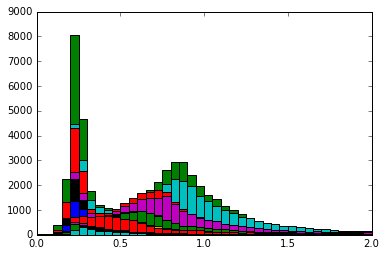

In [38]:
#####For Lambda variables#####

i_1, j_1, _ = plt.hist(mcSignal_18g7a_Hists_04_1_1["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_1['weights'])
k_1, l_1, _ = plt.hist(pPbHists_04_1_1["cluster_Lambda"],bins=40,range=(0,2))

m_1, n_1, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_1["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_1['weights'])
o_1, p_1, _ = plt.hist(pPbHists_04_5_15_1["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_2, j_2, _ = plt.hist(mcSignal_18g7a_Hists_04_1_2["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_2['weights'])
k_2, l_2, _ = plt.hist(pPbHists_04_1_2["cluster_Lambda"],bins=40,range=(0,2))

m_2, n_2, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_2["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_2['weights'])
o_2, p_2, _ = plt.hist(pPbHists_04_5_15_2["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_3, j_3, _ = plt.hist(mcSignal_18g7a_Hists_04_1_3["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_3['weights'])
k_3, l_3, _ = plt.hist(pPbHists_04_1_3["cluster_Lambda"],bins=40,range=(0,2))

m_3, n_3, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_3["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_3['weights'])
o_3, p_3, _ = plt.hist(pPbHists_04_5_15_3["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_4, j_4, _ = plt.hist(mcSignal_18g7a_Hists_04_1_4["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_4['weights'])
k_4, l_4, _ = plt.hist(pPbHists_04_1_4["cluster_Lambda"],bins=40,range=(0,2))

m_4, n_4, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_4["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_4['weights'])
o_4, p_4, _ = plt.hist(pPbHists_04_5_15_4["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_5, j_5, _ = plt.hist(mcSignal_18g7a_Hists_04_1_5["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_5['weights'])
k_5, l_5, _ = plt.hist(pPbHists_04_1_5["cluster_Lambda"],bins=40,range=(0,2))

m_5, n_5, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_5["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_5['weights'])
o_5, p_5, _ = plt.hist(pPbHists_04_5_15_5["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_6, j_6, _ = plt.hist(mcSignal_18g7a_Hists_04_1_6["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_6['weights'])
k_6, l_6, _ = plt.hist(pPbHists_04_1_6["cluster_Lambda"],bins=40,range=(0,2))

m_6, n_6, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_6["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_6['weights'])
o_6, p_6, _ = plt.hist(pPbHists_04_5_15_6["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_7, j_7, _ = plt.hist(mcSignal_18g7a_Hists_04_1_7["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_7['weights'])
k_7, l_7, _ = plt.hist(pPbHists_04_1_7["cluster_Lambda"],bins=40,range=(0,2))

m_7, n_7, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_7["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_7['weights'])
o_7, p_7, _ = plt.hist(pPbHists_04_5_15_7["cluster_Lambda"],bins=40,range=(0,2))

##############################

i_8, j_8, _ = plt.hist(mcSignal_18g7a_Hists_04_1_8["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_1_8['weights'])
k_8, l_8, _ = plt.hist(pPbHists_04_1_8["cluster_Lambda"],bins=40,range=(0,2))

m_8, n_8, _ = plt.hist(mcSignal_18g7a_Hists_04_5_15_8["cluster_Lambda"],bins=40,range=(0,2),weights=mcSignal_18g7a_Hists_04_5_15_8['weights'])
o_8, p_8, _ = plt.hist(pPbHists_04_5_15_8["cluster_Lambda"],bins=40,range=(0,2))

##############################

In [39]:
pPb_ratio_data_1 = np.divide(k_1,o_1)
pPb_ratio_MC_1   = np.divide(i_1,m_1)

pPb_ratio_dataToMC_1 = np.divide(pPb_ratio_data_1,pPb_ratio_MC_1)

##############################

pPb_ratio_data_2 = np.divide(k_2,o_2)
pPb_ratio_MC_2   = np.divide(i_2,m_2)

pPb_ratio_dataToMC_2 = np.divide(pPb_ratio_data_2,pPb_ratio_MC_2)

##############################

pPb_ratio_data_3 = np.divide(k_3,o_3)
pPb_ratio_MC_3   = np.divide(i_3,m_3)

pPb_ratio_dataToMC_3 = np.divide(pPb_ratio_data_3,pPb_ratio_MC_3)

##############################

pPb_ratio_data_4 = np.divide(k_4,o_4)
pPb_ratio_MC_4   = np.divide(i_4,m_4)

pPb_ratio_dataToMC_4 = np.divide(pPb_ratio_data_4,pPb_ratio_MC_4)

##############################

pPb_ratio_data_5 = np.divide(k_5,o_5)
pPb_ratio_MC_5   = np.divide(i_5,m_5)

pPb_ratio_dataToMC_5 = np.divide(pPb_ratio_data_5,pPb_ratio_MC_5)

##############################

pPb_ratio_data_6 = np.divide(k_6,o_6)
pPb_ratio_MC_6   = np.divide(i_6,m_6)

pPb_ratio_dataToMC_6 = np.divide(pPb_ratio_data_6,pPb_ratio_MC_6)

##############################

pPb_ratio_data_7 = np.divide(k_7,o_7)
pPb_ratio_MC_7   = np.divide(i_7,m_7)

pPb_ratio_dataToMC_7 = np.divide(pPb_ratio_data_7,pPb_ratio_MC_7)

##############################

pPb_ratio_data_8 = np.divide(k_8,o_8)
pPb_ratio_MC_8   = np.divide(i_8,m_8)

pPb_ratio_dataToMC_8 = np.divide(pPb_ratio_data_8,pPb_ratio_MC_8)

In [40]:
###Fitting###
def func(x, m, b): 
    
    return m * x + b

popt_1,pcov_1 = curve_fit(func, j_1[10:36], pPb_ratio_dataToMC_1[10:36])

popt_2,pcov_2 = curve_fit(func, j_2[10:36], pPb_ratio_dataToMC_2[10:36])

popt_3,pcov_3 = curve_fit(func, j_3[10:36], pPb_ratio_dataToMC_3[10:36])

popt_4,pcov_4 = curve_fit(func, j_4[10:36], pPb_ratio_dataToMC_4[10:36])

popt_5,pcov_5 = curve_fit(func, j_5[10:36], pPb_ratio_dataToMC_5[10:36])

popt_6,pcov_6 = curve_fit(func, j_6[10:36], pPb_ratio_dataToMC_6[10:36])

popt_7,pcov_7 = curve_fit(func, j_7[10:36], pPb_ratio_dataToMC_7[10:36])

popt_8,pcov_8 = curve_fit(func, j_8[10:36], pPb_ratio_dataToMC_8[10:36])

In [41]:
perr_1 = np.sqrt(np.diag(pcov_1))

perr_2 = np.sqrt(np.diag(pcov_2))

perr_3 = np.sqrt(np.diag(pcov_3))

perr_4 = np.sqrt(np.diag(pcov_4))

perr_5 = np.sqrt(np.diag(pcov_5))

perr_6 = np.sqrt(np.diag(pcov_6))

perr_7 = np.sqrt(np.diag(pcov_7))

perr_8 = np.sqrt(np.diag(pcov_8))

In [44]:
print 'Slope 12.5-13.5 with err:', popt_1[0], ',' , perr_1[0]
print 'Slope 13.5-14.0 with err:', popt_2[0], ',' , perr_2[0]
print 'Slope 14.0-16.0 with err:', popt_3[0], ',' , perr_3[0]
print 'Slope 16.0-18.0 with err:', popt_4[0], ',' , perr_4[0]
print 'Slope 18.0-20.0 with err:', popt_5[0], ',' , perr_5[0]
print 'Slope 20.0-25.0 with err:', popt_6[0], ',' , perr_6[0]
print 'Slope 25.0-30.0 with err:', popt_7[0], ',' , perr_7[0]
print 'Slope 30.0-40.0 with err:', popt_8[0], ',' , perr_8[0]

Slope 12.5-13.5 with err: -0.0306067229943 , 0.0342610229191
Slope 13.5-14.0 with err: -0.109260503225 , 0.1184513482
Slope 14.0-16.0 with err: 0.237161841812 , 0.0579527892025
Slope 16.0-18.0 with err: 0.0327620290709 , 0.0935481035019
Slope 18.0-20.0 with err: 0.343213333956 , 0.182826364752
Slope 20.0-25.0 with err: 0.38536394239 , 0.145444585902
Slope 25.0-30.0 with err: 0.189305506357 , 0.247288257374
Slope 30.0-40.0 with err: -0.424129211777 , 0.265051576543
